In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data

In [2]:
data_path = 'data/'

In [3]:
data = pd.read_csv(f'{data_path}train_phase_1.csv')
data.date = pd.to_datetime(data.date, format='%Y-%m-%d %H:%M:%S')

test = pd.read_csv(f'{data_path}test_phase_1.csv')
test.date = pd.to_datetime(test.date, format='%Y-%m-%d %H:%M:%S')

In [4]:
data.head()

,date,wp1,u,v,ws,wd
0,2009-07-01 01:00:00,0.085,2.34,-0.79,2.47,108.68
1,2009-07-01 02:00:00,0.020,2.18,-0.99,2.40,114.31
2,2009-07-01 03:00:00,0.060,2.20,-1.21,2.51,118.71
3,2009-07-01 04:00:00,0.045,2.35,-1.40,2.73,120.86
4,2009-07-01 05:00:00,0.035,2.53,-1.47,2.93,120.13


In [12]:
data.shape, test.shape

((18756, 6), (7488, 5))

# Checks

First, we check that this data has the exact types we are waiting for.

In [10]:
assert data.dtypes.equals(pd.Series({
    'date': 'datetime64[ns]', 
    'wp1': 'float64', 
    'u': 'float64', 
    'v': 'float64', 
    'ws': 'float64', 
    'wd': 'float64',
}))

assert test.dtypes.equals(pd.Series({
    'date': 'datetime64[ns]', 
    'u': 'float64', 
    'v': 'float64', 
    'ws': 'float64', 
    'wd': 'float64',
}))

Then, we check that we have no NA values in the dataframes.

In [11]:
assert not data.isnull().any(axis=None) and not test.isnull().any(axis=None)

Nice, our data is exactly the types we want, and no NA are present, we can pass on to an exploratory data analysis (EDA).

# EDA and first models

Let's start by checking what we want to predict : the power measurement wp1 of the first farm.

## Wp1

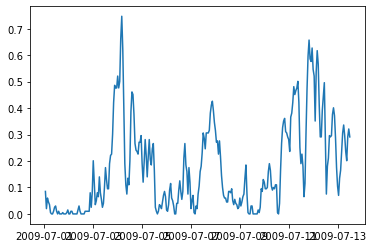

In [12]:
plt.plot(data.head(300).date, data.head(300).wp1)

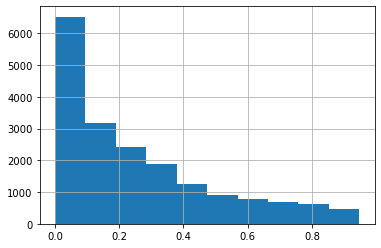

In [13]:
data.wp1.hist()

In [14]:
data.wp1.min(), data.wp1.max()

(0.0, 0.947)

## Windspeed

The Critical parameter in predicting the wind power, obviously seems to be the wind speed. Let us observe this parameter.

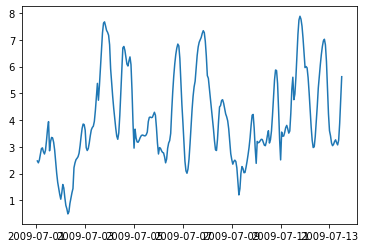

In [15]:
plt.plot(data.head(300).date, data.head(300).ws)

Let's see if there is any correlation between power and speed by taking a look at one of them, function of the other.

Text(0, 0.5, 'windpower')

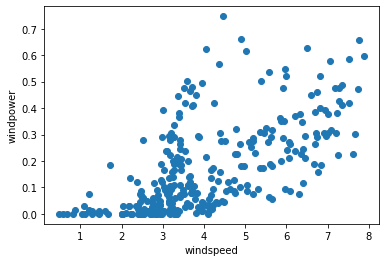

In [16]:
plt.scatter(data.head(300).ws, data.head(300).wp1)
plt.xlabel('windspeed')
plt.ylabel('windpower')


There clearly seems to be a correlation between the two ! When windspeed rises, the wind power rises, on average, even if the relation between the two is not linear. 

We can confirm this by calculating the correlation coeficient betwen the two. Actually we can directly calculate all of the correlation coefficient between all variables in the dataset in one line of code. Let us do so.

In [17]:
data.corr()

,wp1,u,v,ws,wd
wp1,1.000000,0.343465,0.137056,0.723550,-0.178244
u,0.343465,1.000000,-0.042311,0.470191,-0.699384
v,0.137056,-0.042311,1.000000,0.014847,-0.123493
ws,0.723550,0.470191,0.014847,1.000000,-0.182121
wd,-0.178244,-0.699384,-0.123493,-0.182121,1.000000


The correlation coefficient between windpseed and wind powe is 0.7 : this is very high indeed, our firt conclusion were true. Let us recall Pearson's definition of correlation, which is the one we used here.

For a sample, it is defined by : 
    

$$
\frac{\sum \limits _{i=1} ^{n} (x_{i} - \bar x) (y_{i} - \bar y)}{\sqrt{\sum \limits _{i=1} ^{n}(x_{i} - \bar x)^{2}}\sqrt{\sum \limits _{i=1} ^{n}(y_{i} - \bar y)^{2}}} 
$$

What is important to recall is that it is comprised in the range $[-1, 1]$ and : 
    - it is equal to 1 if the two variables are exactly the same
    - -1 if the two varables are the exact opposite
    - when it is equal to 0, the two variables have nothing in common : they are independent one from the other, for example this could be the value of the bitcoin and the average windspeed in south korea, we know these two have nothing in common.
    - when it is > 0, the two variables are positively correlated, this means that on average, when one goes up, the other goes up too.
    - when it is < 0, the two variables are negatively correlated, this means that on average, when one goes up, the other goes down.

Based on this first EDA, a very simple model we can try to predict our sample is to try a linear model : 

$$ wp_{1} = \alpha . ws + \beta$$

In order to do so, we import some libraries that will be useful.

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

We now cut our dataframe in two : one dataframe will be used for training, and the other one will be used to estimate what is the value of this first model we have made. 
For this, why do we not directly use the test set ? The reason is that for the test set, we do not know the exact value of the power measurement.

In [19]:
train, val = train_test_split(data, test_size=0.2, shuffle=True)
print(train.shape, val.shape)

(15004, 6) (3752, 6)


In [20]:
X_train = train['ws'].values.reshape((-1, 1))
y_train = train['wp1'].values

X_val = val['ws'].values.reshape((-1, 1))
y_val = val['wp1'].values

lm = LinearRegression()
lm.fit(X_train, y_train)
mean_absolute_error(lm.predict(X_val), y_val)

0.1283154172057424

Nice ! We have our first model and it gives an error of 0.13 !..

Now wait, what is the value of that first model ? How can we know if 0.13 is actually a good error ? Well for this, a very neat way to be able to know if our model is worth anything is to compare it to a naive model. A naive model can be for example to predict everytime the same value, whatever the conditions. One of these naive model we have at hand would be to predict the mean value of the wind power in the train set. Let's see what would this model give. 

In [21]:
from sklearn.dummy import DummyRegressor

In [22]:
dm = DummyRegressor(strategy='mean')
dm.fit(X_train, y_train)
print(mean_absolute_error(dm.predict(X_val), y_val))

dm = DummyRegressor(strategy='median')
dm.fit(X_train, y_train)
print(mean_absolute_error(dm.predict(X_val), y_val))

0.19788956804127286
0.1901551172707889


Yes ! Good news, our model did really learn something good ! We are a lot better than the 'mean' or 'median' model, around 30% better, based on this metric.

## wind direction, u & v

Now let's take a look at direction.

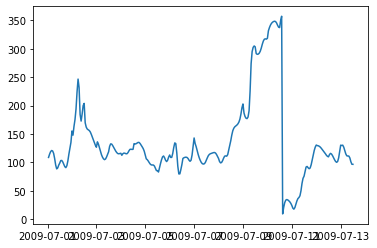

In [23]:
plt.plot(data.head(300).date, data.head(300).wd)

Interesting to see that, as expected, it is comprised between 0 and 360. And when it crosses 360 it goes to 0, as expected for a direction. But this makes it a highly discontinuous function in 360. How should we treat this in the models ? That's a question for you to answer..

One more thing about direction, the wind vector can be either expressed as : 
    - windspeed, and wind direction, 
    - or u and v components. 
These two representations are interchangeable (for math guys, there is a bijection between these two representations)
And in our case, the convention for the wind direction used in our data is wind vector azimuth. For more information on these matters, please check the following website which explains these representations : 
    http://tornado.sfsu.edu/geosciences/classes/m430/Wind/WindDirection.html


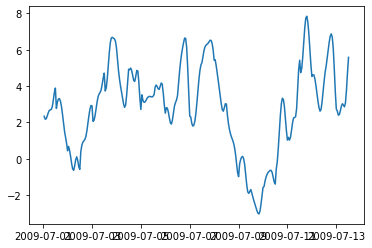

In [24]:
plt.plot(data.head(300).date, data.head(300).u)

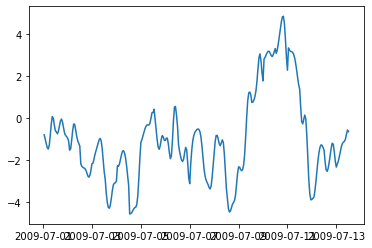

In [25]:
plt.plot(data.head(300).date, data.head(300).v)

# Next steps Modeling

We have already seen first models above : the linear model with one variable (windspeed), and two naive models (median, and mean). It will be your job from now on to determine the best model, but let's already take a look at one classic model that data scientists usually try on for nearly any subject : Random Forest. 

In [26]:
from sklearn.ensemble import RandomForestRegressor

In [27]:
X_train = train[['ws', 'wd', 'u', 'v']].values
y_train = train['wp1'].values

X_val = val[['ws', 'wd', 'u', 'v']].values
y_val = val['wp1'].values

rf = RandomForestRegressor(n_jobs=-1)
rf.fit(X_train, y_train)
print(mean_absolute_error(rf.predict(X_val), y_val))

0.12560590218550108


Random Forest does only very slightly better than the linear model.

# Predictions on test set

Now our model is fit, we can pass on to the predictions. 

In [28]:
X_test = test[['ws', 'wd', 'u', 'v']].values

df_predictions = pd.DataFrame({
    'date': test['date'],
    'wp1': rf.predict(X_test),
})

df_predictions.head()

,date,wp1
0,2011-01-01 01:00:00,0.30797
1,2011-01-01 02:00:00,0.43037
2,2011-01-01 03:00:00,0.38458
3,2011-01-01 04:00:00,0.35139
4,2011-01-01 05:00:00,0.19846


Now it is your turn, what better model can you think of ?